Visualización en Python con Altair
==========================================

* *30 min* | Última modificación: Junio 22, 2019

[Altair](https://altair-viz.github.io/index.html) es una librería de visualización de datos para Python, basada en [Vega](http://vega.github.io/vega) y [Vega-Lite](http://vega.github.io/vega-lite), que usa un lenguaje declarativo que busca minimizar la cantidad de código requerido para la construcción de gráficos. En este tutorial se presentan los principios básicos para la construcción de gráficos para análisis exploratorio de datos, a partir de un caso de aplicación.

## Definición del problema

Se desea construir un gráfico que permita comparar la población por rangos de edades para los distintos continentes, a partir de la información suministrada en el archivo `indicadores mundiales.csv`. El gráfico construído debe ser simiar al siguiente, el cual fue preparado usando [Tableau](https://public.tableau.com/en-us/s/).

![assets/suma-pob-region-edades-4.png](assets/suma-pob-region-edades-4.png)

## Solución

In [1]:
##
## Preparación
##
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import matplotlib as mpl
alt.renderers.enable('notebook');
%matplotlib inline

##
## No funciona en jupyterlab:
##
##     alt.renderers.enable('jupyterlab')
##

### Carga de datos

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/jdvelasq/playground/master/datasets/indicadores-mundiales.csv",
                 sep = ',',           # separador de campos
                 thousands = None,    # separador de miles para números
                 decimal = '.',       # separador de los decimales para números
                 encoding='latin-1')  # idioma

### Preparación de los datos

Para obtener los datos requeridos para la construcción del grafico solicitado, es necesario construir una agregación, sumando la población por región.

In [4]:
df = df.groupby('Region').sum()[['Poblacion 0-14', 'Poblacion 15-64', 'Poblacion 65+']]
df

,Poblacion 0-14,Poblacion 15-64,Poblacion 65+
Region,,,
Asia,5318.6,10668.7,1013.0
Europa,3780.2,13830.6,2890.5
Las Americas,5375.5,10901.8,1223.1
Oceania,1784.8,3133.1,282.5
Oriente Medio,1754.7,3251.1,194.2
africa,11136.2,14452.7,911.7


Altair opera directamente sobre los campos del DataFrame. Por ello, para construir el gráfico solicitado, se requiere cambiar la forma del DataFrame mediante una operación de stack(), así:

In [4]:
df = pd.DataFrame(df.stack())
df

0
Region                                
Asia          Poblacion 0-14    5318.6
              Poblacion 15-64  10668.7
              Poblacion 65+     1013.0
Europa        Poblacion 0-14    3780.2
              Poblacion 15-64  13830.6
              Poblacion 65+     2890.5
Las Americas  Poblacion 0-14    5375.5
              Poblacion 15-64  10901.8
              Poblacion 65+     1223.1
Oceania       Poblacion 0-14    1784.8
              Poblacion 15-64   3133.1
              Poblacion 65+      282.5
Oriente Medio Poblacion 0-14    1754.7
              Poblacion 15-64   3251.1
              Poblacion 65+      194.2
africa        Poblacion 0-14   11136.2
              Poblacion 15-64  14452.7
              Poblacion 65+      911.7

En el DataFrame generado, la columna numérica no tiene nombre y la región y la edad de la población son parte del índice de la tabla. En el siguiente fragmento de código, se agregan las columnas `Region` y `Edad` a partir de la información de índice de las filas, y se cambia el nombre de la última columna a `Poblacion`.

In [5]:
## El índice de cada fila es una tupla con el nombre
## de la región y el rango de edad
for p in df.index:
    print(p)

('Asia', 'Poblacion 0-14')
('Asia', 'Poblacion 15-64')
('Asia', 'Poblacion 65+')
('Europa', 'Poblacion 0-14')
('Europa', 'Poblacion 15-64')
('Europa', 'Poblacion 65+')
('Las Americas', 'Poblacion 0-14')
('Las Americas', 'Poblacion 15-64')
('Las Americas', 'Poblacion 65+')
('Oceania', 'Poblacion 0-14')
('Oceania', 'Poblacion 15-64')
('Oceania', 'Poblacion 65+')
('Oriente Medio', 'Poblacion 0-14')
('Oriente Medio', 'Poblacion 15-64')
('Oriente Medio', 'Poblacion 65+')
('africa', 'Poblacion 0-14')
('africa', 'Poblacion 15-64')
('africa', 'Poblacion 65+')


In [6]:
## Se cambia el nombre de la última columna
df.columns = ['Poblacion']

## Se agrega la columna Region y se 
## extrae la región como la primera componente
## del índice
df['Region'] = [p[0] for p in df.index]

## Se agrega la columna Edad y se extrae como
## la segunda componente del índice
df['Age'] = [p[1] for p in df.index]

## Se cambia el índice por un consecutivo
df.index = range(len(df))

## Se imprime el DataFrame final
df

,Poblacion,Region,Age
0,5318.6,Asia,Poblacion 0-14
1,10668.7,Asia,Poblacion 15-64
2,1013.0,Asia,Poblacion 65+
3,3780.2,Europa,Poblacion 0-14
4,13830.6,Europa,Poblacion 15-64
5,2890.5,Europa,Poblacion 65+
6,5375.5,Las Americas,Poblacion 0-14
7,10901.8,Las Americas,Poblacion 15-64
8,1223.1,Las Americas,Poblacion 65+
9,1784.8,Oceania,Poblacion 0-14


### Construcción del gráfico

Se realiza la primera interación para construir el gráfico. La estructura de un gráfico en Altair siempre es la misma. La componente `mark_bar()` indica el tipo de gráfico. Los campos se indican mediante su nombre, seguido de `:`, seguido del tipo de dato (N: Nominal, Q: Quantity).

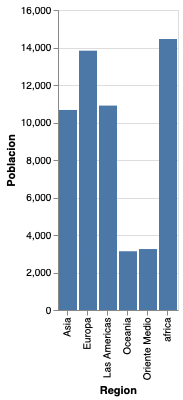

In [7]:
##
## En este primer gráfico, los valores están apilados.
##
alt.Chart(df).mark_bar().encode(
    x = 'Region:N',          # Columna en el eje X          
    y = 'Poblacion:Q'        # Columna en el eje Y
)

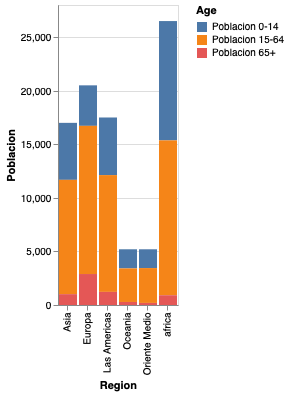

In [8]:
##
## Se cambian los colores para cada rango de edad
##
alt.Chart(df).mark_bar().encode(
    x = 'Region:N',          # Columna en el eje X          
    y = 'Poblacion:Q',       # Columna en el eje Y
    color = 'Age:N'          # Los colores cambian con el
)                            # rango de edad

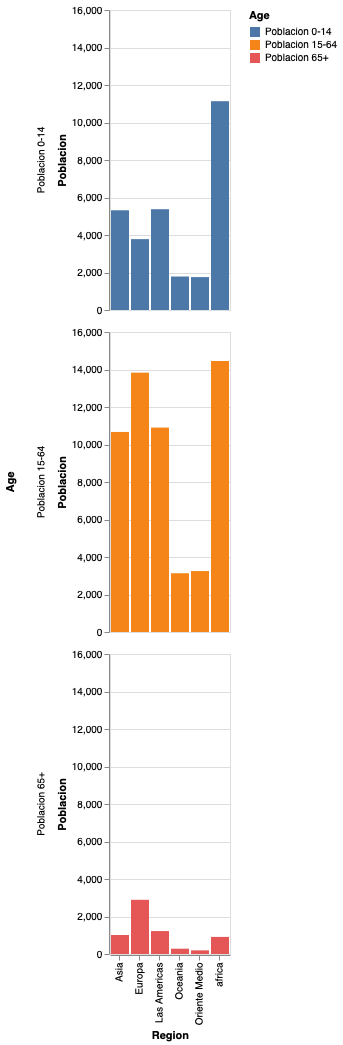

In [9]:
## 
## Para generar un gráfico por cada rango de edad
## se adiciona la propiedad `row` indicando que depende
## de la columna `Age`.
##
alt.Chart(df).mark_bar().encode(
    x = 'Region:N',            
    y = 'Poblacion:Q',
    color = 'Age:N',
    row='Age:N'
)

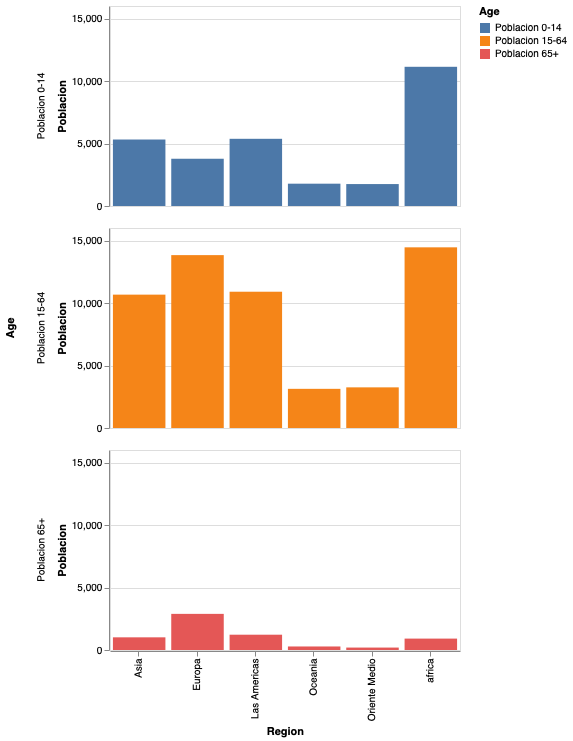

In [10]:
## 
## Se procede a cambiar el tamaño del gráfico
## usando `properties.
##
alt.Chart(df).mark_bar().encode(
    x = 'Region:N',            
    y = 'Poblacion:Q',
    color = 'Age:N',
    row='Age:N'
).properties(width=350, height=200)

### Gráfico Alternativo

Como alternativa, se propone generar un gráfico horizontal, colocando la region en el eje Y y el tamaño de la población en el eje X. Para esto, se invierten los valores de `x` y `y` y se modifica el tamaño de la gráfica.

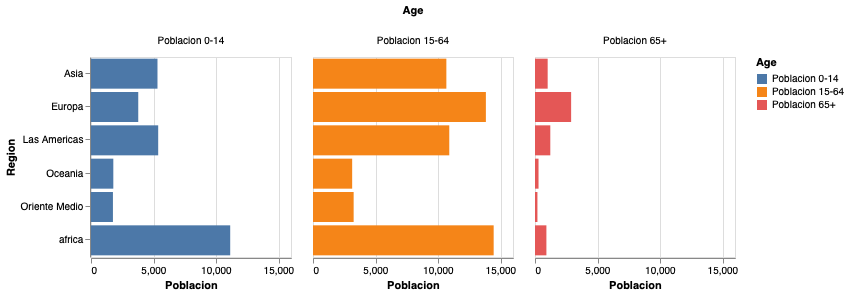

In [11]:
alt.Chart(df).mark_bar().encode(
    x = 'Poblacion:Q',
    y = 'Region:N',            
    color = 'Age:N',
    column='Age:N'
).properties(width=200, height=200)